In [7]:
from dotenv import load_dotenv
import fmpsdk
import pandas as pd
import os

load_dotenv()
apikey = os.environ.get("apikey")
snp500 = pd.DataFrame(fmpsdk.sp500_constituent(apikey))

from fetch import *

file_directories = ['financial-ratios-quarter-20220820.csv']
key_list = [PBR_KEY, PER_KEY]
key = key_list[0]

fetcher = Fetcher()
fetcher.register(key_list=key_list, csv_file_directory=file_directories[0])
from strategy import *

is_absolute = True
relative_value_range_list = [(0,0.2), (0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,0.9)]

filter_list = []
target_key = PBR_KEY
for relative_value_range in relative_value_range_list:
    filter_name = target_key+'=(' + str(relative_value_range[0]) + '-' + str(relative_value_range[1]) + ')'

    absolute_selector = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=(0.0, 500.0), horizon=4, is_absolute=True)
    relative_seletor = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=relative_value_range, horizon=4, is_absolute=False)
    selector_sequence = SelectorSequence(selectors=[absolute_selector, relative_seletor])
    filter_list.append(Filter(selector_sequence_union=[selector_sequence], name=filter_name))


initial_holdings = [Asset(symbol=symbol) for symbol in snp500['symbol']]
start_date = datetime.date(2002, 1, 1)
end_date = datetime.date(2022, 1, 1)
rebalance_dates = pd.date_range(start_date, end_date, freq='3M',inclusive='both')

strategist_list = []
for filter_ in filter_list:
    strategist_name = filter_.name
    strategist = Strategist(fetcher=fetcher, name=strategist_name, asset_pool=initial_holdings,
                            start_date=start_date, end_date=end_date)
    for rebalance_date in rebalance_dates:
        strategist.select_assets(filter=filter_, rebalance_date=rebalance_date.date())
    strategist_list.append(strategist)


In [9]:
from analyze import Analyst

analyst = Analyst(fetcher=fetcher)
analyst.register(table_name='price_list', csv_file_directory='snp500_price_list_19620102_20220814.csv')
analyst.register(table_name='economic_indicators', csv_file_directory='snp500_price_list_19620102_20220814.csv')

for strategist in strategist_list:
    analyst.attach(strategist)

analyst.update_assets_property(PBR_KEY)
analyst.update_assets_property(PER_KEY)

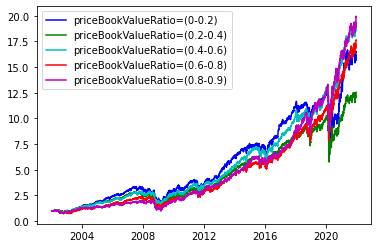

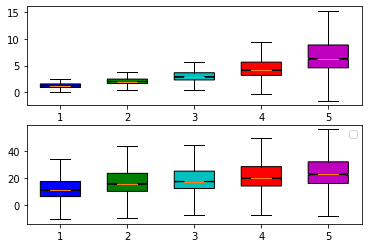

In [10]:
import matplotlib.pyplot as plt
from analyze import StrategyReport

plt.figure(1)
analyst.draw_price_history()
plt.legend()

plt.figure(2)
analyst.draw_property_distributions()
plt.legend()



In [8]:
import pandas as pd
series = pd.Series(index=['A','B','C','D'],data=[1,7,None,8])
series_change = series.pct_change()


A         NaN
B    6.000000
C    0.000000
D    0.142857
dtype: float64